# MURA-Densenet HAND, with extra image augmentation

---


In [1]:
!pip install focal-loss
!pip install keras-radam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-radam: filename=keras_radam-0.15.0-py3-none-any.whl size=14668 sha256=397736b48731eadac27c66c915cdcbd1b6cbf447ef237d2f0bf1bb3d9dff1eec
  Stored in directory: /root/.cache/pip/wheels/e6/e0/44/3d07c185de530721a196a5368d48f6256233337e2c90159f24
Successfully built keras-radam


In [2]:
#with thanks to https://github.com/Hawk453/MURA-DenseNet-Humerus 

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

os.chdir('/content/drive/My Drive/MURA')

In [5]:
pwd


'/content/drive/My Drive/MURA'

In [6]:
import os

os.listdir()

['MURA-v1.1',
 'MURA-DenseNet-v1.7-Humerus.h5',
 'MURA-DenseNet-HAND.h5',
 'train_image_data.csv',
 'valid_image_data.csv',
 'MURA-DenseNet-HAND-widthshift.h5']

In [7]:
import os


def listdir_nohidden(path):
    '''
    Utility function to find the list of files in a directory excluding the hidden files.
    Args:
        path: contains the path of the directory containing the images

    '''
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [8]:
import os

import pandas as pd


def create_images_metadata_csv(category,study_types):
    '''
    This function creates a csv file containing the path of images, label.
    Args:
        category: train or valid, depending on which csv is needed
        study_types: the type of the body part in MURA Dataset, eg:  XR_SHOULDER
    '''
    image_data = {}
    study_label = {'positive': 1, 'negative': 0}
    study_types = ['XR_HAND']

    i = 0
    image_data[category] = pd.DataFrame(columns=['Path','Count', 'Label'])
    for study_type in study_types: # Iterate throught every study type
        DATA_DIR = 'MURA-v1.1/%s/%s/' % (category, study_type)
        patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if study == '.DS_Store':
                    continue

                label = study_label[study.split('_')[1]]
                path = DATA_DIR + patient + '/' + study + '/'
                for j in range(len(list(listdir_nohidden(path)))):
                    image_path = path + 'image%s.png' % (j + 1)
                    image_data[category].loc[i] = [image_path, 1, label]
                    i += 1
    image_data[category].to_csv(category+"_image_data.csv",index = None, header=False)

In [9]:
import numpy as np


def getImageLabels(dataframe):
  '''
  This function is to get the labels of the images from the dataframe
  Args:
      dataframe: pandas dataframe containing the labels of the images

  '''
  labels = [data['Label'] for (_, data) in tqdm(dataframe.iterrows())]

  labels = np.asarray(labels)
  return labels

In [10]:
import numpy as np


def getImage(dataframe, size):
    '''
    Function to process the images
    Args:
        dataframe: contains the path to the images in the directory
        size: contains the value to which the shape of the image will resized
    '''
    images = []
    for _, data in tqdm(dataframe.iterrows()):
      try:
        image = cv2.imread(data['Path'])
        image = cv2.resize(image,(size,size))
        images.append(image)

      except Exception as e:
        print(str(e))

    images = np.asarray(images).astype('float32')

    mean = np.mean(images)            #normalization
    std = np.std(images)
    images = (images - mean) / std

    return images

In [11]:
def build_model():
    base_model = DenseNet169(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')

    #Freeze PreTrained Weights so only the new layer is updated
    #for layer in base_model.layers:

    x = base_model.output

    predictions = Dense(n_classes,activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=predictions)

### Data Preprocessing


In [12]:
# Data processing #


img_width, img_height = 224, 224
#Keras ImageDataGenerator to load, transform the images of the dataset

IMG_DATA_DIR = 'MURA-v1.1/'
train_data_dir = IMG_DATA_DIR + 'train/XR_HAND'
valid_data_dir = IMG_DATA_DIR + 'valid/XR_HAND'

train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)
study_types = ['XR_HAND']

#TRAIN DATA
create_images_metadata_csv('train',study_types)
#VALID DATA
create_images_metadata_csv('valid',study_types)

100%|██████████| 159/159 [00:00<00:00, 194.70it/s]


In [13]:
import pandas as pd

valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])
train_image_df = pd.read_csv('train_image_data.csv', names=['Path', 'Count','Label'])

dd = {'train': train_image_df, 'valid': valid_image_df}

In [14]:
train_image_labels = getImageLabels(train_image_df)

5543it [00:00, 25154.37it/s]


In [15]:
train_images = getImage(train_image_df, size = 224)

5543it [40:41,  2.27it/s]


(5543, 224, 224, 3)

In [17]:
train_datagen.fit(train_images,augment=True)

In [18]:
train_generator = train_datagen.flow(
    x=train_images,
    y=train_image_labels,
    batch_size = 32
)

In [19]:
valid_image_labels = getImageLabels(valid_image_df)

460it [00:00, 14166.41it/s]


In [20]:
valid_images = getImage(valid_image_df, size = 224)

460it [03:34,  2.15it/s]


In [21]:
test_datagen.fit(valid_images,augment=True)

In [22]:
validation_generator = test_datagen.flow(
    x=valid_images,
    y=valid_image_labels,
    batch_size = 1
)

### DenseNet Model


In [23]:
# Construct model


nb_train_samples = len(train_images)
nb_validation_samples = len(valid_images)
epochs = 12
batch_size = 32
steps_per_epoch = nb_train_samples//batch_size
print(steps_per_epoch)
n_classes = 1

173


In [24]:
#Building a model
input_shape = (224, 224, 1)

model = build_model()
# Build optimizer


model.compile(loss=BinaryFocalLoss(gamma = 2), optimizer='SGD', metrics=['acc', 'mse'])

51877672/51877672 [==============================] - 2s 0us/step


In [25]:
#callbacks for early stopping incase of reduced learning rate, loss unimprovement
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_lr=0.0001)
callbacks_list = [early_stop, reduce_lr]

In [26]:
#train the module
model_history = model.fit(
    train_generator,
    epochs=epochs,
    workers=0,
    use_multiprocessing=False,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples //batch_size,
    callbacks=callbacks_list

)

Epoch 1/12
173/173 [==============================] - 157s 508ms/step - loss: 0.1639 - acc: 0.7115 - mse: 0.2011 - val_loss: 0.1736 - val_acc: 0.7143 - val_mse: 0.2200 - lr: 0.0100
Epoch 2/12
173/173 [==============================] - ETA: 0s - loss: 0.1346 - acc: 0.7619 - mse: 0.1791
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
173/173 [==============================] - 81s 465ms/step - loss: 0.1346 - acc: 0.7619 - mse: 0.1791 - val_loss: 0.2805 - val_acc: 0.5714 - val_mse: 0.2491 - lr: 0.0100
Epoch 3/12
173/173 [==============================] - 83s 482ms/step - loss: 0.1143 - acc: 0.8118 - mse: 0.1630 - val_loss: 0.1338 - val_acc: 0.7857 - val_mse: 0.1850 - lr: 1.0000e-03
Epoch 4/12
173/173 [==============================] - ETA: 0s - loss: 0.1129 - acc: 0.8104 - mse: 0.1643
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001.
173/173 [==============================] - 80s 460ms/step - loss: 0.1129 - acc: 0.8104 - mse: 0.1643 - val_loss: 0.2376

In [27]:
model.save("MURA-DenseNet-HAND-widthshift.h5")

In [28]:
ev = model.evaluate(
    validation_generator, steps=nb_validation_samples, workers=0, use_multiprocessing=False
)

460/460 [==============================] - 16s 36ms/step - loss: 0.1496 - acc: 0.7109 - mse: 0.1913


0.710869550704956

### Performance Evaluation


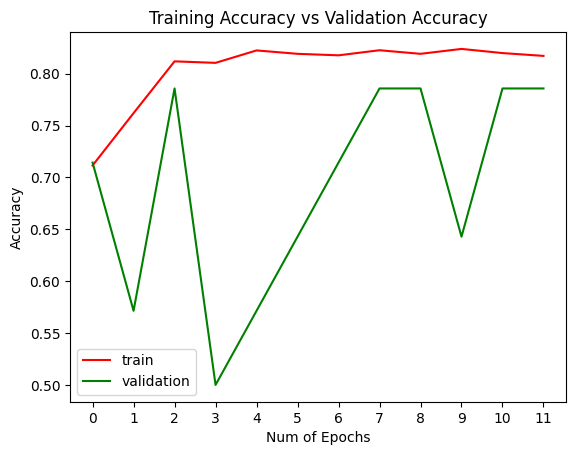

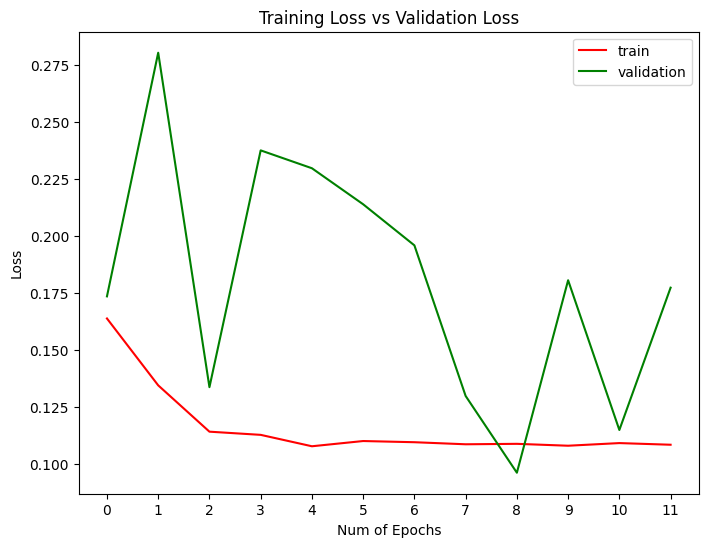

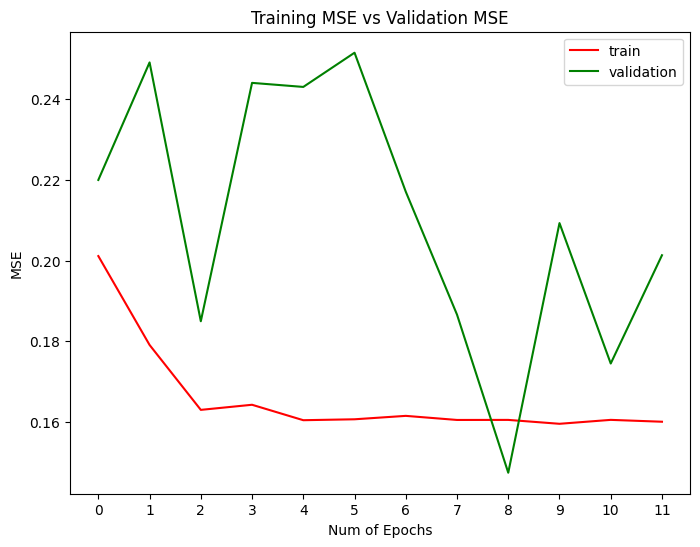

In [30]:
validation_generator.reset()
pred_batch = model.predict_on_batch(valid_images)

In [31]:
predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

In [32]:
import numpy as np

error = np.sum(np.not_equal(predictions, valid_image_labels)) / valid_image_labels.shape[0]
pred = predictions

### Confusion Matric


Confusion Matrix


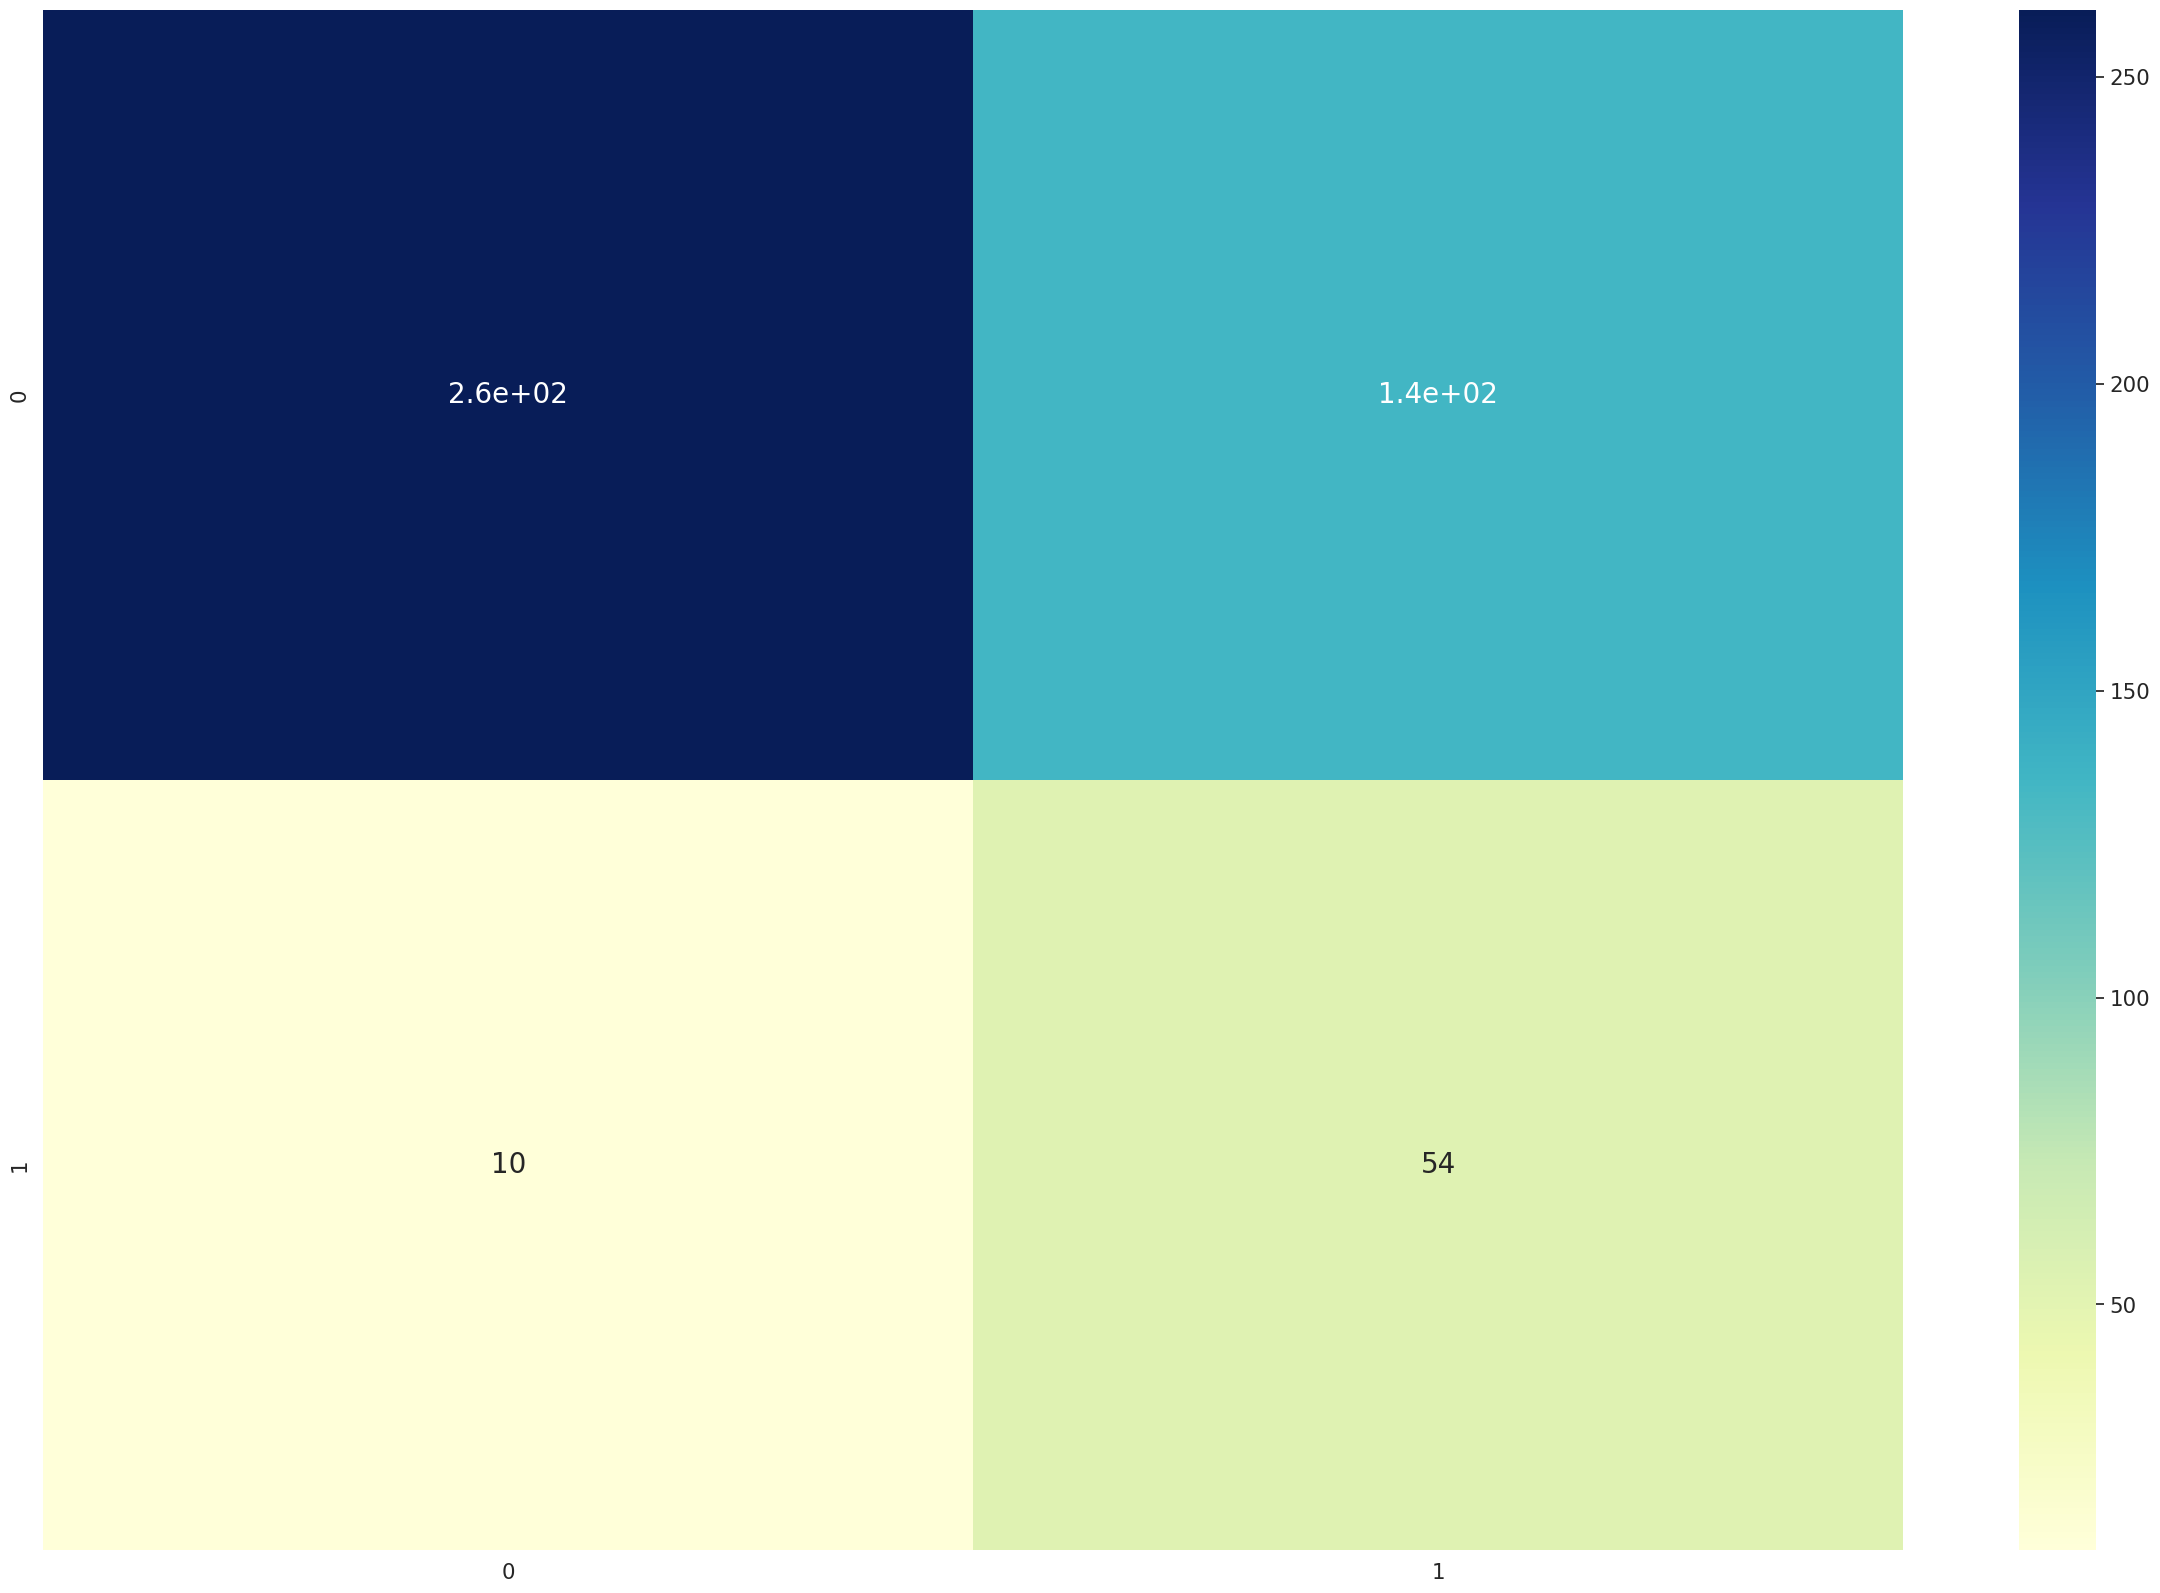

In [33]:
import matplotlib.pyplot as plt

print('Confusion Matrix')
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix( pred ,valid_image_labels)
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

### Kappa score


In [34]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(valid_image_labels, pred)

0.27647850045559064

### Classification report


In [35]:
print()
print('Classification Report')
print(classification_report(valid_image_labels, pred, target_names=["0","1"]))


Classification Report
              precision    recall  f1-score   support

           0       0.66      0.96      0.78       271
           1       0.84      0.29      0.43       189

    accuracy                           0.68       460
   macro avg       0.75      0.62      0.60       460
weighted avg       0.73      0.68      0.64       460



### ROC score


In [36]:
from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_image_labels, pred_batch)

In [37]:
from sklearn.metrics import auc

auc_keras = auc(fpr_keras, tpr_keras)

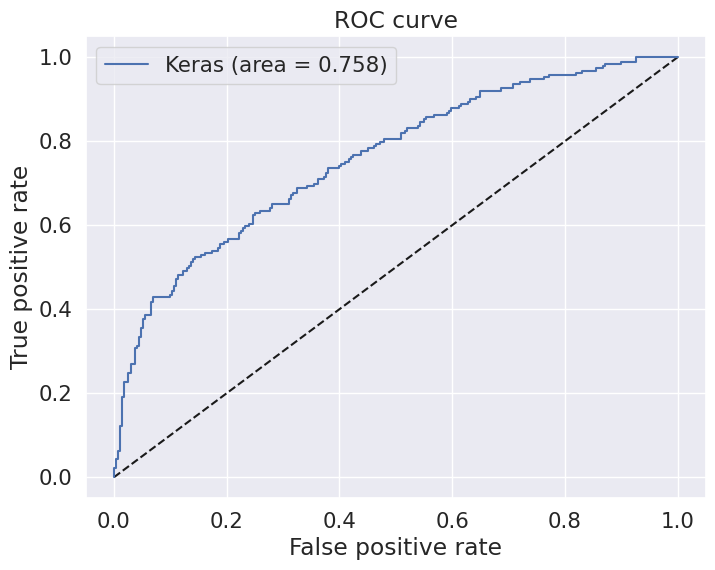

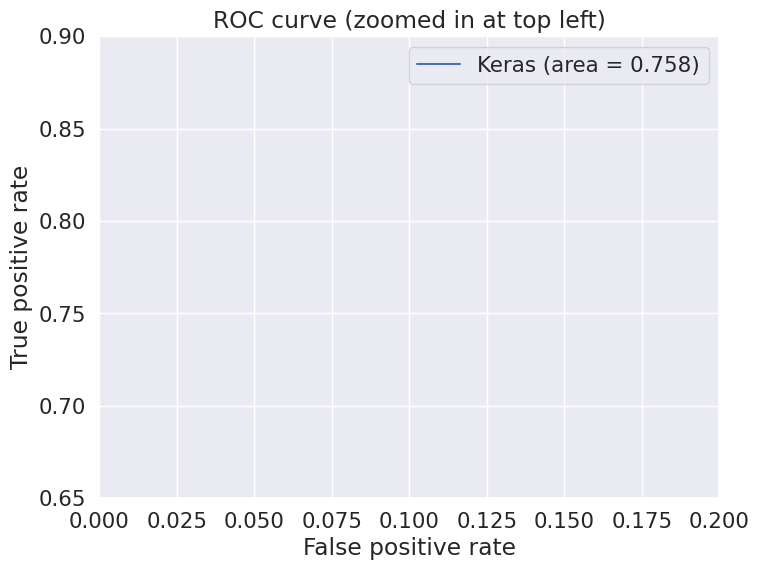

In [38]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.2)
plt.ylim(0.65, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()